In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Progbar
import os
import cv2

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# rediseñar tamaño a 64 x 64 

In [3]:
# Directorio donde se encuentran las imágenes originales de 200x200
original_dir = "./simpsons_dataset/cropped"

# Directorio donde guardarás las imágenes redimensionadas de 64x64
resized_dir = "./simpsons_dataset_resized/cropped"

In [3]:
# # Asegúrate de que el directorio de salida exista
# os.makedirs(resized_dir, exist_ok=True)

# # Lista de archivos en el directorio original
# files = os.listdir(original_dir)

# # Itera a través de los archivos y redimensiona las imágenes
# for file in files:
#     if file.endswith(".png"):
#         image = cv2.imread(os.path.join(original_dir, file))
#         resized_image = cv2.resize(image, (64, 64))
#         cv2.imwrite(os.path.join(resized_dir, file), resized_image)

# print("Imágenes redimensionadas y guardadas en el directorio:", resized_dir)

In [4]:
# Configura la ruta a tus datos
data_dir = "./simpsons_dataset_resized/"

# Asegúrate de que las imágenes sean del mismo tamaño
img_height = 64
img_width = 64
batch_size = 150

In [5]:
# Crea un generador de datos
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # validation_split=0.2
)


In [6]:
# Carga las imágenes desde el directorio
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='input',  # Utilizaremos las imágenes originales como objetivo
    subset='training'
)

Found 9877 images belonging to 1 classes.


In [7]:
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='input',
    subset='validation'
)


Found 0 images belonging to 1 classes.


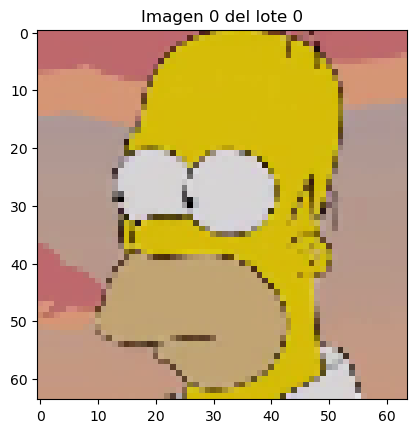

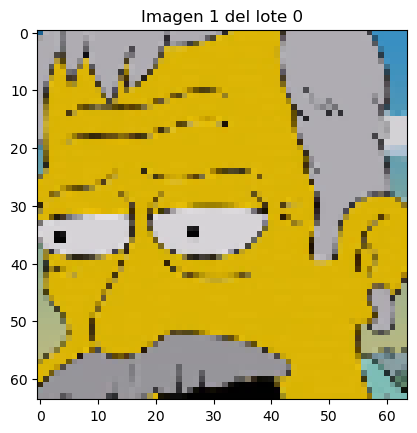

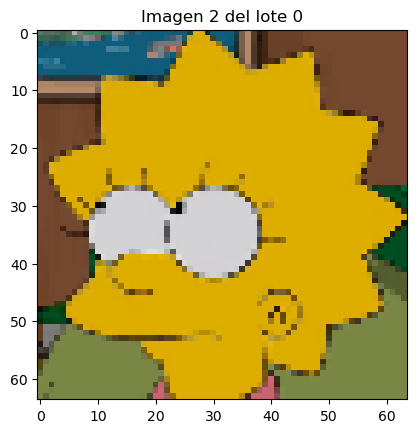

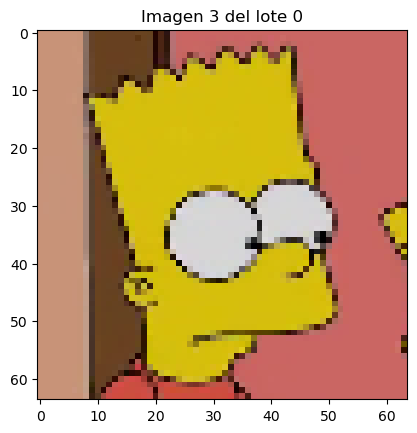

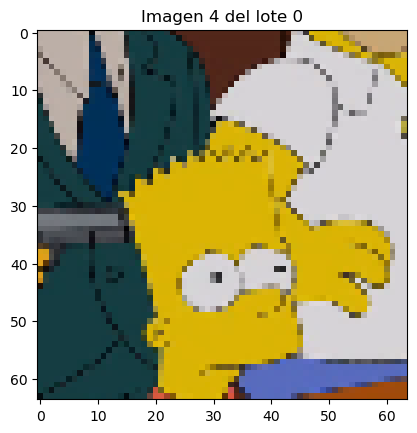

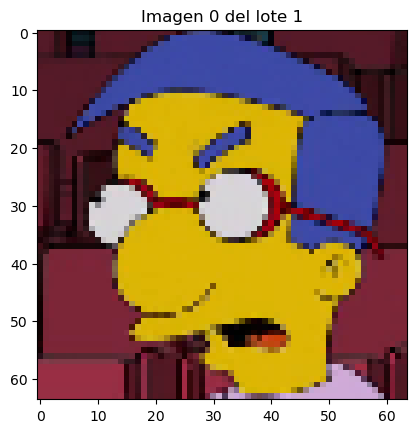

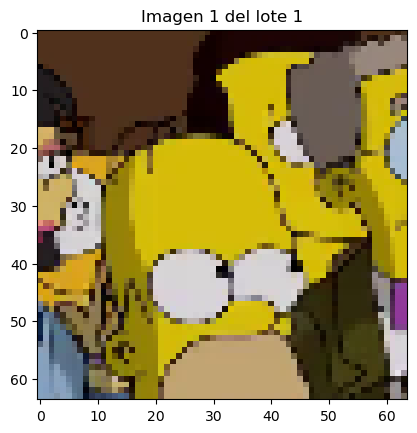

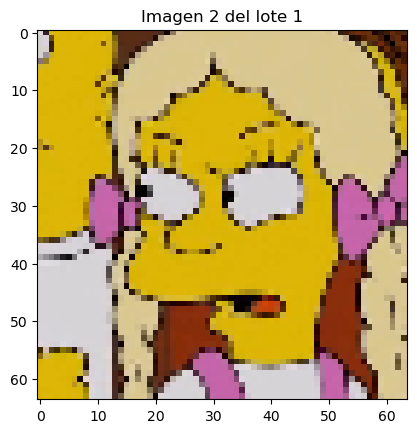

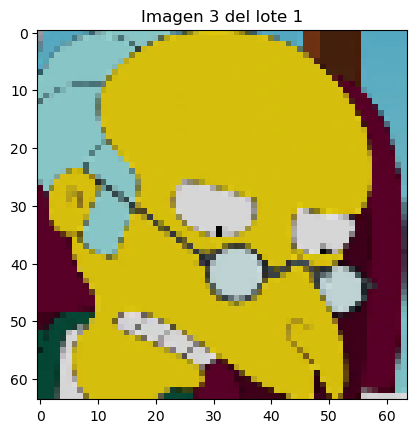

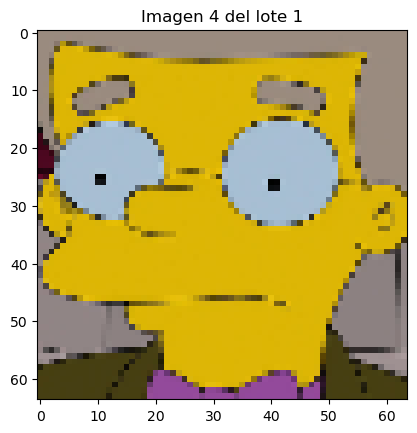

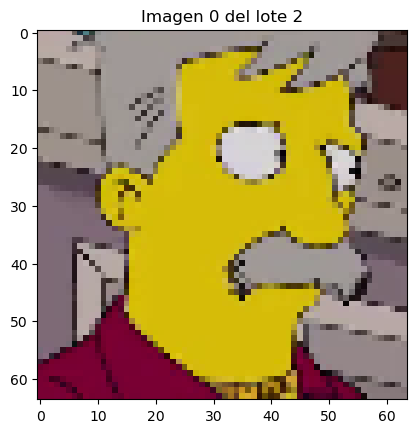

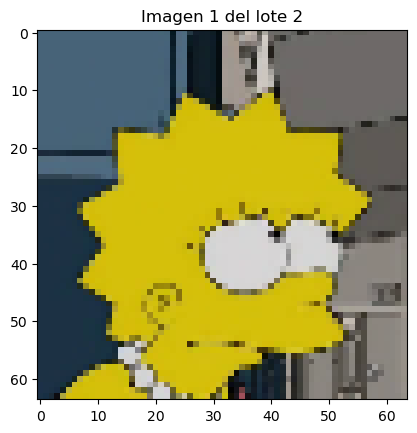

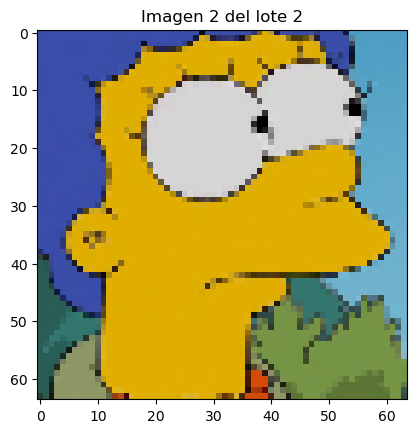

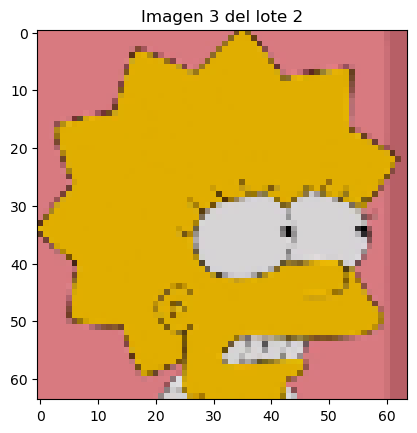

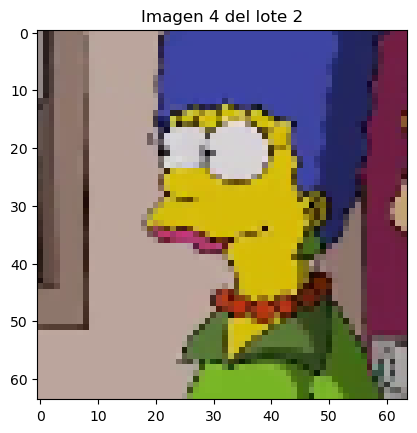

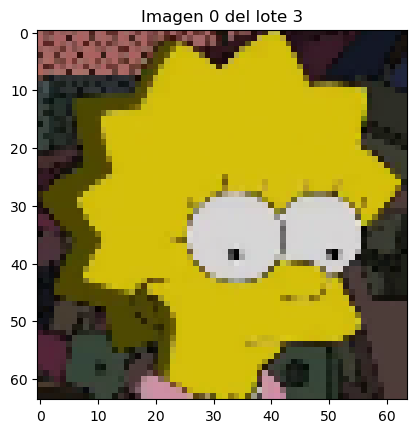

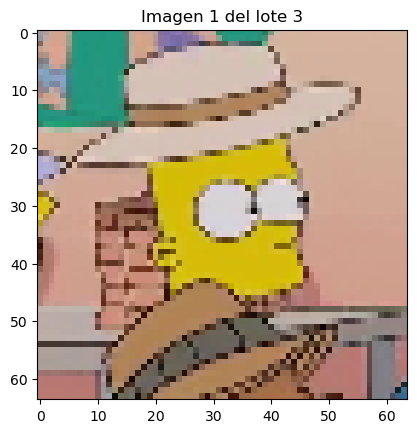

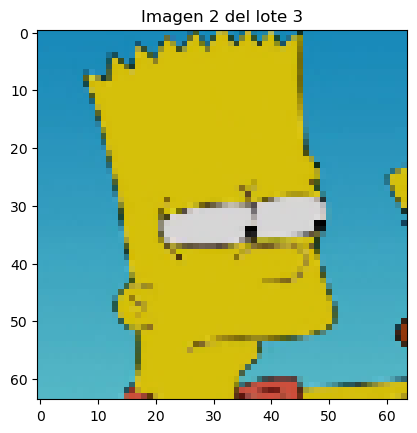

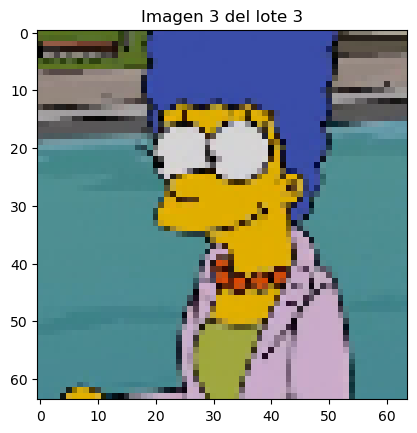

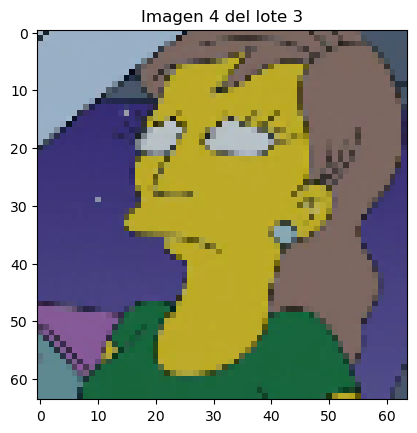

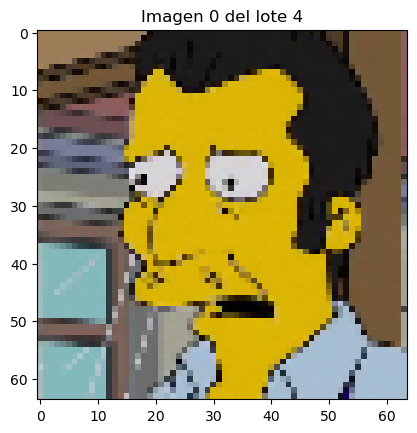

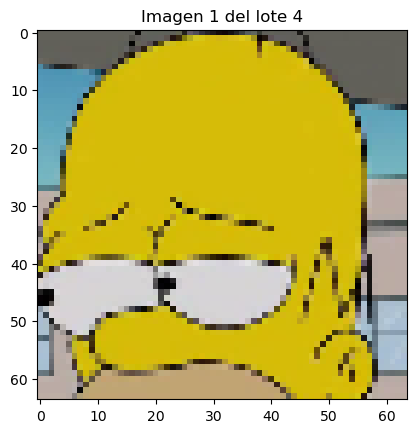

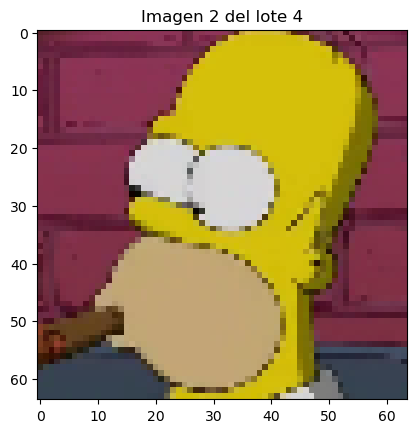

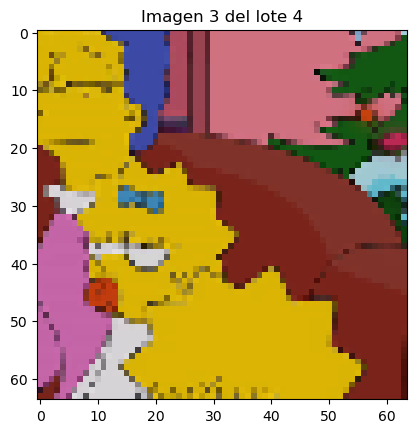

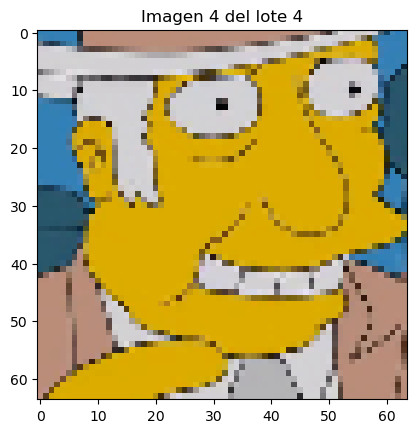

In [8]:
# Itera a través de los primeros 5 lotes de imágenes
for i in range(5):
    batch = next(train_generator)
    images = batch[0]  # El primer elemento del lote es un arreglo de imágenes
    labels = batch[1]  # El segundo elemento del lote son las etiquetas (en este caso, las propias imágenes)

    for j in range(5):
        plt.imshow(images[j])  # Muestra la imagen
        plt.title(f"Imagen {j} del lote {i}")
        plt.show()

# Construir el generador y el discriminador

In [83]:
def build_discriminator():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(1, (3, 3), padding='same'))
    model.add(layers.Activation('sigmoid'))


    return model


def build_generator():
    model = keras.Sequential()
    model.add(layers.Dense(3 * 64 * 64, input_dim=100))
    model.add(layers.Reshape((64, 64, 3)))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(3, (3, 3), activation='tanh', padding='same', use_bias=False))

    return model


generator = build_generator()
discriminator = build_discriminator()



## Funciones de perdidas

In [84]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



## Entrenamiento

In [85]:
@tf.function
def train_step(images, _):  # Añade una segunda variable para las etiquetas
    # Genera un vector aleatorio con una distribución normal
    noise = tf.random.normal([batch_size, 100], mean=0.0, stddev=1.0)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss  # Devuelve las pérdidas


In [94]:
def train(dataset, epochs):
    steps_per_epoch = dataset.samples // dataset.batch_size  # Calcula el número de lotes
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        progbar = Progbar(target=steps_per_epoch)  # Inicializa la barra de progreso
        for i in range(steps_per_epoch):  # Utiliza steps_per_epoch en lugar de iterar a través de dataset
            image_batch = next(dataset)7
            gen_loss, disc_loss = train_step(*image_batch)  # Asegúrate de que train_step devuelva las pérdidas
            values = [('gen_loss', float(gen_loss)), ('disc_loss', float(disc_loss))]
            progbar.update(i+1, values=values)  # Actualiza la barra de progreso

# Define el número de épocas y entrena el modelo
num_epochs = 100
train(train_generator, num_epochs)



Epoch 1/100
65/65 [==============================] - 354s 5s/step - gen_loss: 1.0310 - disc_loss: 1.1300

Epoch 2/100
65/65 [==============================] - 338s 5s/step - gen_loss: 1.2534 - disc_loss: 0.9775

Epoch 3/100
65/65 [==============================] - 339s 5s/step - gen_loss: 1.6770 - disc_loss: 0.8168

Epoch 4/100
65/65 [==============================] - 337s 5s/step - gen_loss: 1.6892 - disc_loss: 0.8997

Epoch 5/100
65/65 [==============================] - 345s 5s/step - gen_loss: 2.1094 - disc_loss: 0.7844

Epoch 6/100
65/65 [==============================] - 354s 5s/step - gen_loss: 1.2550 - disc_loss: 1.1109

Epoch 7/100
65/65 [==============================] - 355s 5s/step - gen_loss: 1.2363 - disc_loss: 0.9527

Epoch 8/100
65/65 [==============================] - 355s 5s/step - gen_loss: 1.8146 - disc_loss: 0.8627

Epoch 9/100
65/65 [==============================] - 356s 5s/step - gen_loss: 1.6289 - disc_loss: 0.7627

Epoch 10/100
65/65 [=========================

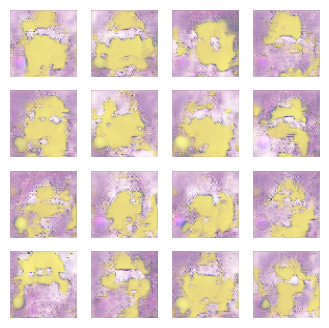

In [95]:
def generate_and_save_images(model, epoch, test_input):
    # Asegúrate de que el modelo esté en modo de evaluación
    predictions = model(test_input, training=False)

    # Escala las imágenes entre 0 y 1
    predictions = (predictions + 1) / 2.0

    # Muestra las imágenes
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    # Guarda las imágenes
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Genera ruido aleatorio
test_input = tf.random.normal([16, 100])

# Genera imágenes y guárdalas
generate_and_save_images(generator, num_epochs, test_input)


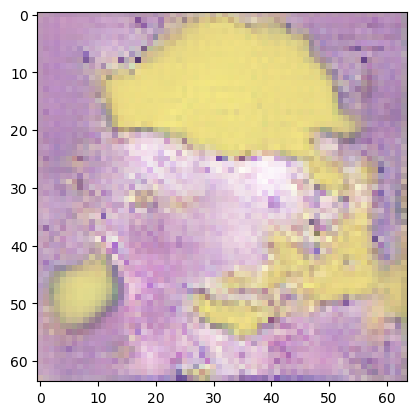

In [106]:
def generate_new_image(generator):
    # Genera ruido aleatorio
    noise = tf.random.normal([1, 100])

    # Usa el generador para crear una nueva imagen
    generated_image = generator(noise, training=False)

    # Procesa la imagen generada
    generated_image = (generated_image + 1) / 2  # Mapea el rango de píxeles a [0, 1]
    generated_image = np.clip(generated_image, 0, 1)
    generated_image = generated_image[0]  # Elimina la dimensión de lote
    generated_image = np.uint8(generated_image * 255)  # Mapea el rango de píxeles a [0, 255]

    return generated_image

# Genera una nueva imagen
new_image = generate_new_image(generator)

# Muestra la nueva imagen
plt.imshow(new_image)
plt.show()
